In [1]:
# IMPORTS
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
# DATASET
df = pd.read_csv("../datasets/stroke/healthcare-dataset-stroke-data_train.csv")
df.drop(["id", "Unnamed: 0"], axis=1, inplace=True)

### BMI por edad (medianas)
* Hasta:  10 años - BMI: 18.30  
* Hasta:  20 años - BMI: 23.80  
* Hasta:  30 años - BMI: 26.70  
* Hasta:  40 años - BMI: 29.70  
* Hasta:  50 años - BMI: 30.00  
* Hasta:  60 años - BMI: 30.90  
* Hasta:  70 años - BMI: 30.00  
* Mayor 70 años - BMI: 28.30  
* Mayor 30 años - BMI: 29.80  

Hago grupos hasta 10, hasta 20, hasta 30 y mayor a 30 para rellenar NaNs.

In [3]:
bmi_fill = {
    "hasta_10": 18.3,
    "hasta_20": 23.8,
    "hasta_30": 26.7,
    "mayor_30": 29.8,
}

In [4]:
# LLENO NaNs SEGUN EDAD
df.bmi.fillna(0, inplace=True)
for i in range(len(df)):
    if df.bmi.iloc[i] == 0:
        if (df.age.iloc[i]<=10):
            df.bmi.iloc[i] = bmi_fill["hasta_10"]
        elif (df.age.loc[i]<=20)&(df.age.loc[i]>10):
            df.bmi.iloc[i] = bmi_fill["hasta_20"]
        elif (df.age.loc[i]<=30)&(df.age.loc[i]>20):
            df.bmi.iloc[i] = bmi_fill["hasta_30"]
        else:
            df.bmi.iloc[i] = bmi_fill["mayor_30"]

/home/pablo/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


## ENCODING

In [5]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder

## La idea ahora sería hacerle OHE a work_type y smoking_status; y label encoding a gender y Residence_type, y después probar de nuevo los modelos.  
Quizás habría que usar el ColumnTransformer?

In [6]:
ohe_cols = ["work_type", "smoking_status"]
label_cols = ["gender", "ever_married", "Residence_type"]
cat_cols = ohe_cols+label_cols
num_cols = ["avg_glucose_level", "bmi"]

In [7]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

class ModifiedLabelEncoder(LabelEncoder):

    def fit_transform(self, y, *args, **kwargs):
        return super().fit_transform(y).reshape(-1, 1)

    def transform(self, y, *args, **kwargs):
        return super().transform(y).reshape(-1, 1)

# num_pipeline = Pipeline(["std_scaler", StandardScaler()])

# label_pipeline = Pipeline(["label_enc", LabelEncoder()])

# ohe_pipeline = Pipeline(["ohe", OneHotEncoder()])

full_pipeline = ColumnTransformer([
    ("num", StandardScaler(), num_cols),
    ("ohe", OneHotEncoder(), ohe_cols),
    ("label_1", ModifiedLabelEncoder(), label_cols[0]),
    ("label_2", ModifiedLabelEncoder(), label_cols[1]),
    ("label_3", ModifiedLabelEncoder(), label_cols[2]),
])

In [8]:
df_prepared = full_pipeline.fit_transform(df)

In [9]:
df_processed = pd.DataFrame(df_prepared)
# df_processed.columns = num_cols + ohe_cols + label_cols

In [10]:
df_processed[0].to_numpy().std()

1.0

In [11]:
df_listo = pd.concat([df_processed, df[["hypertension", "heart_disease"]]], axis=1)

In [12]:
df_listo

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,hypertension,heart_disease
0,-0.896710,-0.390718,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0,0
1,-1.039486,0.074254,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0,0
2,-0.886402,-0.933185,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0,0
3,-0.742529,-0.067821,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0,0
4,-0.509613,0.100085,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4083,-0.143132,-1.372325,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0,0
4084,0.958504,-0.468213,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0,0
4085,-0.086109,0.048422,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0,0
4086,-0.129973,2.747841,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0,0


## MODELOS

In [19]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix, accuracy_score

lr = LogisticRegression()
lr.fit(df_listo, df.stroke)
ypred = cross_val_predict(lr, df_listo, df.stroke)
y_score_log = cross_val_predict(lr, df_listo, df.stroke, method="predict_proba")
confusion_matrix(df.stroke, ypred)

array([[3884,    0],
       [ 204,    0]])

In [20]:
print(accuracy_score(df.stroke, ypred))
print(recall_score(df.stroke, ypred))

0.9500978473581213
0.0


In [16]:
# Con pesos
pesos = {0:1, 1:10}
lr = LogisticRegression(class_weight="balanced")
lr.fit(df_listo, df.stroke)
ypred = cross_val_predict(lr, df_listo, df.stroke)
y_score_log = cross_val_predict(lr, df_listo, df.stroke, method="predict_proba")
confusion_matrix(df.stroke, ypred)

array([[2715, 1169],
       [  67,  137]])

In [18]:
from sklearn.metrics import recall_score

print(accuracy_score(df.stroke, ypred))
print(recall_score(df.stroke, ypred))

0.6976516634050881
0.6715686274509803


In [112]:
df_listo

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,hypertension,heart_disease
0,-0.896710,-0.386927,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0,0
1,-1.039486,0.070569,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0,0
2,-0.886402,-0.920673,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0,0
3,-0.742529,-0.069221,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0,0
4,-0.509613,0.095986,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4083,-0.143132,NaN,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0,0
4084,0.958504,-0.463177,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0,0
4085,-0.086109,0.045153,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0,0
4086,-0.129973,2.701174,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0,0


# Red Neuronal Artificial, ANN

In [15]:
from tensorflow import keras
import tensorflow as tf

In [16]:
from sklearn.model_selection import train_test_split
X_train, X_val, t_train, t_val = train_test_split(df_listo, df.stroke, test_size=0.15)

In [36]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [37]:
#Definimos una capa especial, que es la entrada del modelo:
input_ = keras.layers.Input(shape=[df_listo.shape[1]])
#Luego se instancia cada capa y se aplica como una función a la salida de la capa anterior

hidden1 = keras.layers.Dense(40, activation="relu")(input_)
drop1 = keras.layers.Dropout(0.2)(hidden1)
hidden2 = keras.layers.Dense(20, activation="relu")(drop1)
drop2 = keras.layers.Dropout(0.2)(hidden2)
hidden3 = keras.layers.Dense(10, activation="relu")(drop2)
drop3 = keras.layers.Dropout(0.2)(hidden3)
output = keras.layers.Dense(1, activation="sigmoid")(drop3)

#Cuando se haya llegado a las las salidas, podemos definir el modelo:
model = keras.models.Model(inputs=[input_], outputs=[output])

In [38]:
early = keras.callbacks.EarlyStopping(patience=17, restore_best_weights=True)
model.compile(loss="binary_crossentropy",
              optimizer="sgd",
              metrics=["accuracy",])

In [39]:
#Cuantas capas hay?
model.layers

In [40]:
#cómo es el modelo?
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 16)]              0         
_________________________________________________________________
dense (Dense)                (None, 40)                680       
_________________________________________________________________
dropout (Dropout)            (None, 40)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 20)                820       
_________________________________________________________________
dropout_1 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                210       
_________________________________________________________________
dropout_2 (Dropout)          (None, 10)                0     

In [41]:
pesos = {0:1.0, 1:25}
history = model.fit(epochs=100, batch_size=32, x=X_train, y= t_train, validation_data=(X_val, t_val), callbacks=[early,], class_weight=pesos)

Epoch 1/100
109/109 [==============================] - 1s 3ms/step - loss: 1.5000 - accuracy: 0.2242 - val_loss: 0.8171 - val_accuracy: 0.0586
Epoch 2/100
109/109 [==============================] - 0s 1ms/step - loss: 1.4606 - accuracy: 0.1382 - val_loss: 0.7948 - val_accuracy: 0.1270
Epoch 3/100
109/109 [==============================] - 0s 1ms/step - loss: 1.4552 - accuracy: 0.2499 - val_loss: 0.8230 - val_accuracy: 0.1352
Epoch 4/100
109/109 [==============================] - 0s 1ms/step - loss: 1.4122 - accuracy: 0.3230 - val_loss: 0.8213 - val_accuracy: 0.2883
Epoch 5/100
109/109 [==============================] - 0s 1ms/step - loss: 1.4151 - accuracy: 0.4039 - val_loss: 0.7912 - val_accuracy: 0.4218
Epoch 6/100
109/109 [==============================] - 0s 1ms/step - loss: 1.4433 - accuracy: 0.4571 - val_loss: 0.7680 - val_accuracy: 0.5033
Epoch 7/100
109/109 [==============================] - 0s 1ms/step - loss: 1.4088 - accuracy: 0.5006 - val_loss: 0.7634 - val_accuracy: 0.5358

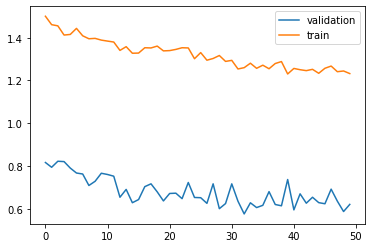

In [42]:
history.history.keys()
plt.plot(history.history.get('val_loss'), label="validation")
plt.plot(history.history.get('loss'), label="train")
plt.legend()

In [51]:
y_pred_score = model.predict(df_listo)
y_pred = np.zeros(len(y_pred_score))
for i in range(len(y_pred_score)):
    if(y_pred_score[i,0] > 0.5 ):
        y_pred[i] = 1

In [52]:
model.evaluate(df_listo, df.stroke)

128/128 [==============================] - 0s 843us/step - loss: 0.5908 - accuracy: 0.6605


[0.5907881855964661, 0.660469651222229]

In [53]:
from sklearn.metrics import confusion_matrix
confusion_matrix(df.stroke, y_pred)

array([[2544, 1340],
       [  48,  156]])

In [ ]:
#No correr
confusion_matrix(df.stroke, y_pred)#no olvidar que use una red con dos capas dense una de 300 y otra de 100 y pesos 0:1 1:100
#[1657, 2227],
#[   9,  195]

array([[1657, 2227],
       [   9,  195]])